In [57]:
import numpy as np
import pickle
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx


In [2]:
# load in data
with open('/Users/rohanramesh/Documents/SportsData/NBA/AllYearlyData_2008_2018.pickle', 'rb') as handle:
    df_all_stats = pickle.load(handle)

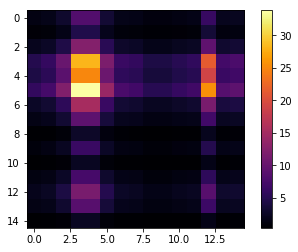

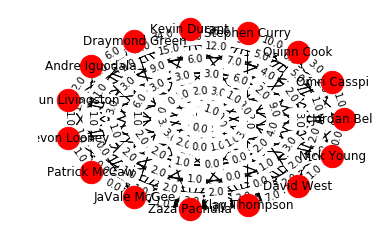

In [92]:
# Lets have team we play with be the GS Warriors in 2018
idx = (df_all_stats['2018']['Tm'] == "GSW") & (df_all_stats['2018']['MP_adv'] > 200)
GSW_team = df_all_stats['2018'][['Player','AST','PS/G']][idx]
curr_team_ast_pts = GSW_team[['AST', 'PS/G']].values
summed_ast_pts = curr_team_ast_pts.sum(axis=0)
# lets make a matrix of all pairwise comparisons
all_pairwise_edges = np.ndarray(shape= (np.shape(curr_team_ast_pts)[0],np.shape(curr_team_ast_pts)[0]))
# build the ratio for edges = (AST for a person / AST total) * (PTS for a person / PTS total)
for i in range(0,np.shape(curr_team_ast_pts)[0]):
    for j in range(0,np.shape(curr_team_ast_pts)[0]):
        all_pairwise_edges[i,j] = 1000* curr_team_ast_pts[i][0]/summed_ast_pts[0] * curr_team_ast_pts[j][1]/summed_ast_pts[1]
# print(GSW_team)
cm = plt.get_cmap('inferno')
plt.imshow(all_pairwise_edges, cmap=cm)
plt.colorbar()
plt.show()

# for the nodes lets use player names
pnames = GSW_team['Player'].tolist()
G = nx.DiGraph()
G.add_nodes_from(pnames)
for i in range(0,np.shape(curr_team_ast_pts)[0]):
    for j in range(0,np.shape(curr_team_ast_pts)[0]):
        G.add_edge(pnames[i],pnames[j],weight= all_pairwise_edges[i,j])

# arcs = nx.draw_networkx_edges(G, pos=nx.spring_layout(G))
pos=nx.shell_layout(G)
edge_labels=dict([((u,v,),round(d['weight']))
                 for u,v,d in G.edges(data=True)])
# nx.draw(G,pos,arrows= False,edge_cmap=cm)
# nx.draw_networkx_nodes(G, pos)
# # we can now added edge thickness and edge color
# nx.draw_networkx_edges(G, pos)
A = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=500,with_labels = True,edge_cmap=plt.cm.Reds)
# pylab.show()
# print(G.edges())
# nx.draw(G, with_labels=True, font_weight='bold', arrows=False, edge_cmap= cm, edge_vmin=0, edge_vmax= 0.035)

In [6]:
print(list(df_all_stats['2018']))

['', '2P', '2P%', '2P%_per100', '2P/FG', '2P/FG_per100', '2P/PS', '2P/PS_per100', '2PA', '2PA/FGA', '2PA/FGA_per100', '2PA_per100', '2P_per100', '3P', '3P%', '3P%_per100', '3P/FG', '3P/FG_per100', '3P/PS', '3P/PS_per100', '3PA', '3PA/FGA', '3PA/FGA_per100', '3PA_per100', '3PAr', '3P_per100', 'AST', 'AST%', 'AST_per100', 'Age', 'Age_adv', 'Age_per100', 'BLK', 'BLK%', 'BLK_per100', 'BPM', 'DBPM', 'DRB', 'DRB%', 'DRB_per100', 'DRtg', 'DWS', 'FG', 'FG%', 'FG%_per100', 'FGA', 'FGA_per100', 'FG_per100', 'FT', 'FT%', 'FT%_per100', 'FTA', 'FTA_per100', 'FT_per100', 'FTr', 'G', 'GS', 'GS_per100', 'G_adv', 'G_per100', 'MP', 'MP_adv', 'MP_per100', 'OBPM', 'ORB', 'ORB%', 'ORB_per100', 'ORtg', 'OWS', 'PER', 'PF', 'PF_per100', 'PS/G', 'PTS', 'Player', 'Pos', 'STL', 'STL%', 'STL_per100', 'TOV', 'TOV%', 'TOV_per100', 'TRB', 'TRB%', 'TRB_per100', 'TS%', 'Tm', 'USG%', 'VORP', 'WS', 'WS/48', 'd2P%', 'd2P%_per100', 'd2PA', 'd2PA_per100', 'd3P', 'd3P%', 'd3P%_per100', 'd3P/PS', 'd3P/PS_per100', 'd3PA', 'd3

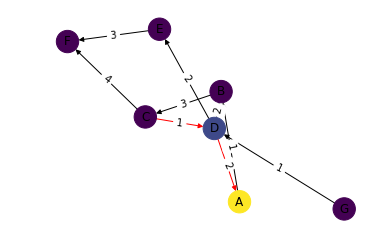

In [84]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab

G = nx.DiGraph()

G.add_edges_from([('A', 'B'),('C','D'),('G','D')], weight=1)
G.add_edges_from([('D','A'),('D','E'),('B','D'),('D','E')], weight=2)
G.add_edges_from([('B','C'),('E','F')], weight=3)
G.add_edges_from([('C','F')], weight=4)


val_map = {'A': 1.0,
                   'D': 0.5714285714285714,
                              'H': 0.0}

values = [val_map.get(node, 0.45) for node in G.nodes()]
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
red_edges = [('C','D'),('D','A')]
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]

pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_color = values, node_size=500,with_labels = True,edge_color=edge_colors,edge_cmap=plt.cm.Reds)
pylab.show()